# An ESN simulating Lorenz '63

<small> Following <em> Using machine learning to replicate chaotic attractors and calculate Lyapunov exponents from data</em>, Pathak et. al., 2017, https://doi.org/10.1063/1.5010300 </small>

$\begin{align} 
    \dot{x} &= \sigma(y-x) \\
    \dot{y} &= x (\rho - z) -y \\
    \dot{z} &= xy - \beta z
\end{align} $

- $\rho=28$, $\sigma=10$, $\beta=8/3$

- Initial value $(x,y,z) = (0.1,0.1,0.1)$

- Timestep size $\Delta t = 0.02$

- Number of timesteps: $T$

Let $\textbf{u} = (x,y,z)$, time discretization: $\mathbf{u}_{k+1} = \mathbf{u}_{k} + \Delta t\:F(\mathbf{u}_{k}) $

Data is given by    $\: \mathbf{u}_k , ~\mathbf{y}_k = \mathbf{u}_{k+1}$, for $k = 1,\ldots,T $ and $N_u = N_y = 3$

## Lorenz '63 data
Input and output: $~~U \in \mathbb{R}^{T \times N_u}  $, $~~Y \in \mathbb{R}^{T \times N_y} $

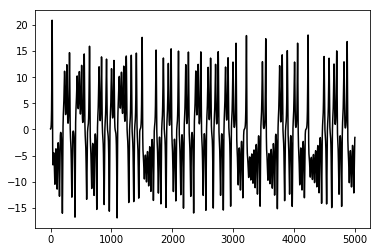

In [85]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from Lorenz63.dataGen import DataGen
from matplotlib import pyplot as plt
rng  = np.random

dt   = 0.02   # time step
Ttrn = 100    # training samples
Tprd = 25     # reference samples for prediction 
T    = int(Ttrn / dt) # number of training time steps
data = DataGen(T+int(Tprd/dt))
U, Y = data.createLorenz63(0.02, [0.1,0.1,0.1])

# separate part of the data for testing
testU = U[T:]; testY = Y[T:]
U     = U[:T]; Y     = Y[:T]

plt.plot(U[0:T-1,0],color='k'); plt.show()

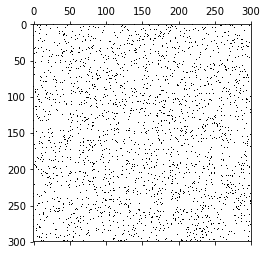

In [86]:
## Setup $W$ and $W_{in}$

Nu = U.shape[1]     # input data size
Ny = Y.shape[1]     # output data size
nPredictions = testU.shape[0]  # number of prediction steps

Nr       = 300      # reservoir size
rhoMax   = 1.2      # spectral radius
sparsity = .95      # sparsity

# Create input weight matrix
W_in = rng.rand(Nr, Nu) * 2 - 1

# Create sparse weight matrix W
W = rng.rand(Nr, Nr) - 0.5
W[rng.rand(*W.shape) < sparsity] = 0

# Set spectral radius
rho = np.linalg.eigvals(W)
W   = W * rhoMax / np.max(np.abs(rho)); fig = plt.spy(W)

In [87]:
# Normalize data
scaleU = 1/np.abs(U).max()  # input scaling
scaleY = 1/np.abs(Y).max()  # output scaling
U = scaleU * U
Y = scaleY * Y

## Define the state update
$ \mathbf{x}_k = \tanh(W\:\mathbf{x}_{k-1} + W_{in}\:\mathbf{u}_k)$

In [88]:
def update(state, u):
    pre = np.dot(W, state) + np.dot(W_in, u)
    act = np.tanh(pre)
    return act

# Evolve the state $\to X \in \mathbb{R}^{T \times N_r}$  
<img src="ESN4.png" width="800" float='right'/>

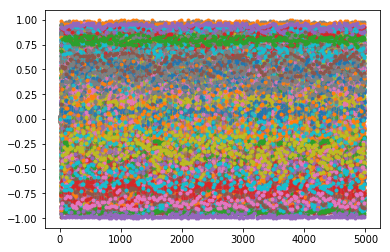

In [89]:
X = np.zeros( (T, Nr) ) # initialize activations X
for k in range(1, T) :
    X[k, :] = update(X[k-1, :], U[k, :])
    
samples = np.arange(5,5000,20)
plt.plot(samples,X[samples],marker='.',linewidth='.1'); plt.show()

## Fit the output weight matrix $W_{out} \in \mathbb{R}^{N_y \times N_r}$  
$Y \in \mathbb{R}^{T \times N_y}$, 
$X \in \mathbb{R}^{T \times N_r}$  
Use linear regression to solve $~W_{out} X^T = {Y}^T $ 

In [90]:
# compute pseudo inverse of X
P = np.linalg.pinv(X)

$W_{out} = {Y}^T (X^T)^\dagger = {Y}^T (X^\dagger)^T = (X^\dagger {Y})^T$

In [91]:
W_out = np.dot(P, (Y)).T

### Training error  
- Compute predicted output $\hat{Y}^T = W_{out} X^T $  
- Compute/check $~\text{E}(\hat{Y}, Y)= \sqrt{\langle \|\hat{Y}-Y \|^2 \rangle} $

In [92]:
# training output
predY  = (np.dot(X, W_out.T))
print("training error:"); print(np.sqrt(np.mean((predY - Y)**2)))

training error:
3.3088450791231545e-05


## Simulate the dynamical system
<img src = "ESN5.png?1" width = "800" />


In [93]:
# initialize the reservoir state with the last one during training
state = X[-1,:]

# initialize the output array with the last one during training
predY = np.vstack([ Y[-1,:], np.zeros((nPredictions, Ny))])

$
\begin{align}
\mathbf{x}_k &= \tanh(W\:\mathbf{x}_{k-1} + W_{in}\:\mathbf{y}_{k-1}) \\
\mathbf{y}_k &= W_{out}\:\mathbf{x}_k
\end{align}
$

In [94]:
for k in range(nPredictions):
    state = update(state, predY[k,:])
    predY[k+1,:] = np.dot(W_out, state)

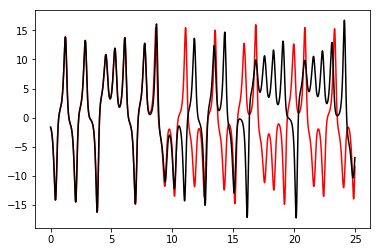

In [95]:
# remove inital value
predY = predY[1:]

# unscale
predY = predY / scaleY

time = dt*np.arange(0,predY.shape[0])
plt.plot(time, predY[:,0],color='r');
plt.plot(time, testY[:,0],color='k');

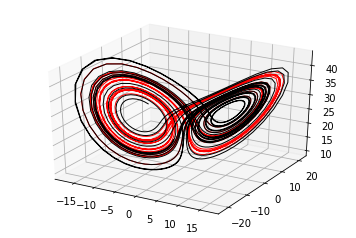

In [96]:
fig = plt.figure();
ax  = fig.add_subplot(111, projection='3d');
ax.plot(predY[:,0], predY[:,1], predY[:,2], linewidth=1, color='r');
ax.plot(testY[:,0], testY[:,1], testY[:,2], linewidth=1, color='k');

# ESN extended architecture
Adding a few connections makes this network already much more robust. However that also introduces more tunables.
<img src = "ESN6.png?1" width = "800" />


